<a href="https://colab.research.google.com/github/rdemarqui/sentiment_analysis/blob/main/02%20Vectorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis
## Vectorization

In [13]:
seed_value = 42

In [14]:
import multiprocessing, os, time
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn import metrics
from lightgbm import LGBMClassifier
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
np.random.seed(seed_value)

In [ ]:
path = os.getcwd()
path

'/content'

In [ ]:
cores = multiprocessing.cpu_count()
cores

2

In [ ]:
def vector_method_score(X_train, y_train, X_test, y_test, n_splits=5, shuffle=True, scoring='roc_auc'):
  # Check cross-validation score
  kfold = KFold(n_splits=n_splits, shuffle=shuffle, random_state=seed_value)
  model = LGBMClassifier(n_jobs=-1, verbose=-1, random_state=seed_value)
  scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
  cv_score = np.round(scores, 5)

  # Check test score
  model.fit(X_train, y_train);
  y_pred = model.predict_proba(X_test)[:,1]
  test_score = np.round(metrics.roc_auc_score(y_test, y_pred), 5)

  return cv_score, test_score

In [ ]:
def pipeline(X_train, y_train, X_test, y_test, vect_function, **kwargs):
  start_time = time.time()
  dict_csv_score = {}
  dict_test_score = {}

  for preproc_method in X_train.columns:
    print(f"Running: {preproc_method}")
    X_train_vec, X_test_vec = vect_function(X_train[preproc_method], X_test[preproc_method])
    cv_score, test_score = vector_method_score(X_train_vec, y_train, X_test_vec, y_test)

    dict_csv_score[preproc_method] = cv_score
    dict_test_score[preproc_method] = [test_score]

  end_time = time.time()
  execution_time = end_time - start_time
  hours, remainder = divmod(int(execution_time), 3600)
  minutes, seconds = divmod(remainder, 60)
  print(f"\nExecution time: {hours:02d}:{minutes:02d}:{seconds:02d}")

  return dict_csv_score, dict_test_score

In [ ]:
def create_score_table(cv_score, test_score):
  df_score = pd.DataFrame(cv_score).T
  df_score['train_mean'] = df_score.mean(axis=1)
  df_score['test'] = pd.DataFrame(test_score).T

  return df_score

## Dataset
---

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from itertools import chain

In [ ]:
try:
  df = pd.read_csv(os.path.join(path, 'data\preprocessed_corpus.zip'),
                   sep=',', compression='zip')
except:
  !wget https://github.com/rdemarqui/sentiment_analysis/raw/main/data/preprocessed_corpus.zip -q
  df = pd.read_csv(os.path.join(path, 'preprocessed_corpus.zip'),
                   sep=',', compression='zip')

In [ ]:
columns = ['review_text_clean', 'review_text_clean_stop', 'review_text_clean_stem',
           'review_text_clean_stop_stem', 'review_text_clean_lemma', 'review_text_clean_stop_lemma',
           'overall_rating']
corpus = df[columns].copy()
corpus['overall_rating'] = corpus['overall_rating'].apply(lambda x: 1 if x >= 4 else 0)
corpus = corpus.dropna()
print(corpus.shape)

(113005, 7)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(corpus.iloc[:, :-1], corpus.iloc[:, -1:],
                                                    test_size=0.2, random_state=seed_value)

In [ ]:
X_train.head()

,review_text_clean,review_text_clean_stop,review_text_clean_stem,review_text_clean_stop_stem,review_text_clean_lemma,review_text_clean_stop_lemma
77662,adorei produto muito pratico serviu ao propros...,adorei produto pratico serviu proprosito prome...,ador produt muit pra serv ao proprosit promet,ador produt pra serv proprosit promet,adorar produto muito pratico servir a o propro...,adorar produto pratico servir proprosito prometer
78184,meu produto veio danificado porem nao sera mot...,produto veio danificado porem motivo devolucao...,meu produt vei danific por nao ser motiv par d...,produt vei danific por motiv devoluca obrig,meu produto vir danificar porem nao sera motiv...,produto vir danificar porem motivo devolucao o...
105690,otimo produto travesseiro maravilhoso quantida...,otimo produto travesseiro maravilhoso quantida...,otim produt travess maravilh quant muit boa de...,otim produt travess maravilh quant boa pen gan...,otimo produto travesseiro maravilhoso quantida...,otimo produto travesseiro maravilhoso quantida...
96751,otima aquisicao agua geladinha fresca designer...,otima aquisicao agua geladinha fresca designer...,otim aquisica agu gel fresc design bonit ador ...,otim aquisica agu gel fresc design bonit ador ...,otimo aquisicao aguo geladinho fresco designer...,otimo aquisicao aguo geladinho fresco designer...
49691,produto atende corresponde as especificacoes s...,produto atende corresponde especificacoes cont...,produt atend correspond as especificaco sem co...,produt atend correspond especificaco cont pen ...,produto atender corresponder o especificacoe s...,produto atender corresponder especificacoes co...


In [ ]:
# Checking y proportion
print(f'Train proportion\n{y_train.value_counts()/y_train.shape[0]}')

Train proportion
overall_rating
1                 0.700323
0                 0.299677
dtype: float64


In [ ]:
X_train = X_train.astype(str)
y_train = y_train.values.ravel()
X_test = X_test.astype(str)
y_test = y_test.values.ravel()

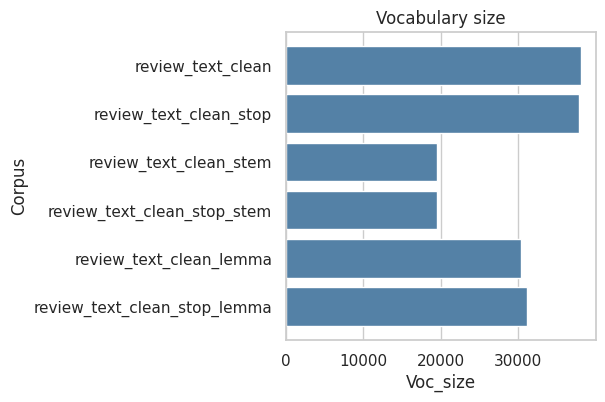

In [ ]:
# Check Vocabulary size
plt.figure(figsize=(4, 4))
voc_size = {}
for column in X_train.columns:
  full_text = ' '.join(X_train[column].tolist())
  words = full_text.split()
  vocabulary = set(words)
  voc_size[column] = len(vocabulary)

df_vocabulary_size = pd.DataFrame(list(voc_size.items()), columns=['Corpus', 'Voc_size'])

ax = sns.barplot(x='Voc_size', y='Corpus',
                 data=df_vocabulary_size,
                 orient='h', color='steelblue')
plt.title('Vocabulary size')
plt.plot();

## Sparse
---

### Bag of Word
___

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
def apply_bag_of_word(X_train, X_test):
  vectorizer = CountVectorizer(lowercase=False, dtype=np.float32)
  X_train_vec = vectorizer.fit_transform(X_train)
  X_test_vec = vectorizer.transform(X_test)

  return X_train_vec, X_test_vec

In [ ]:
cv_score_bow, test_score_bow = pipeline(X_train, y_train,
                                        X_test, y_test,
                                        apply_bag_of_word)

Running: review_text_clean
Running: review_text_clean_stop
Running: review_text_clean_stem
Running: review_text_clean_stop_stem
Running: review_text_clean_lemma
Running: review_text_clean_stop_lemma

Execution time: 00:04:56


In [ ]:
df_score_bow = create_score_table(cv_score_bow, test_score_bow)
df_score_bow

,0,1,2,3,4,train_mean,test
review_text_clean,0.97844,0.97962,0.97932,0.97953,0.98056,0.979494,0.97790
review_text_clean_stop,0.97225,0.97122,0.97212,0.97027,0.97296,0.971764,0.97048
review_text_clean_stem,0.97942,0.98028,0.97947,0.98015,0.98120,0.980104,0.97894
review_text_clean_stop_stem,0.97264,0.97255,0.97281,0.97183,0.97446,0.972858,0.97228
review_text_clean_lemma,0.97825,0.97962,0.97927,0.97966,0.98104,0.979568,0.97847
review_text_clean_stop_lemma,0.97202,0.97071,0.97222,0.97110,0.97353,0.971916,0.97080


### TF-IDF
---

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
def apply_tf_idf(X_train, X_test):
  vectorizer = TfidfVectorizer(lowercase=False, dtype=np.float32)
  X_train_vec = vectorizer.fit_transform(X_train)
  X_test_vec = vectorizer.transform(X_test)

  return X_train_vec, X_test_vec

In [ ]:
cv_score_tfidf, test_score_tfidf = pipeline(X_train, y_train,
                                            X_test, y_test,
                                            apply_tf_idf)

Running: review_text_clean
Running: review_text_clean_stop
Running: review_text_clean_stem
Running: review_text_clean_stop_stem
Running: review_text_clean_lemma
Running: review_text_clean_stop_lemma

Execution time: 00:10:06


In [ ]:
df_score_tfidf = create_score_table(cv_score_tfidf, test_score_tfidf)
df_score_tfidf

,0,1,2,3,4,train_mean,test
review_text_clean,0.97865,0.97960,0.97946,0.97966,0.98097,0.979668,0.97811
review_text_clean_stop,0.97287,0.97207,0.97290,0.97109,0.97396,0.972578,0.97143
review_text_clean_stem,0.97990,0.98048,0.97988,0.98017,0.98159,0.980404,0.97907
review_text_clean_stop_stem,0.97401,0.97337,0.97333,0.97262,0.97531,0.973728,0.97280
review_text_clean_lemma,0.97880,0.97958,0.97954,0.97997,0.98132,0.979842,0.97882
review_text_clean_stop_lemma,0.97272,0.97125,0.97255,0.97151,0.97390,0.972386,0.97166


## Dense
___

### Word2vec
___

In [ ]:
from gensim.models import Word2Vec

In [ ]:
def apply_word2vec(X_train, X_test, sg=0):
  X_train_tokenized = [text.split() for text in X_train.values.tolist()]
  X_test_tokenized = [text.split() for text in X_test.values.tolist()]

  vectorizer = Word2Vec(vector_size=300, sg=sg, workers=cores)
  vectorizer.build_vocab(X_train_tokenized)
  vectorizer.train(X_train_tokenized, total_examples=vectorizer.corpus_count, epochs=vectorizer.epochs)

  # A random vector for OOV it's better than zeros vector, because model can learn something
  vector_shape = vectorizer.wv[list(vectorizer.wv.key_to_index)[0]].shape
  np.random.seed(seed_value)
  UNK_TOKEN = np.random.rand(*vector_shape)

  def get_word_vector(word):
    return vectorizer.wv[word] if word in vectorizer.wv else UNK_TOKEN

  X_train_vec = [[get_word_vector(word) for word in text] for text in X_train_tokenized]
  X_test_vec = [[get_word_vector(word) for word in text] for text in X_test_tokenized]

  # Get mean of word vectors for each text
  X_train_vec = [np.mean(np.array(vector).T, axis=1) for vector in X_train_vec]
  X_test_vec = [np.mean(np.array(vector).T, axis=1) for vector in X_test_vec]

  return X_train_vec, X_test_vec

#### CBOW - Continuous Bag of Words
___

In [ ]:
cv_score_cbow, test_score_cbow = pipeline(X_train, y_train,
                                          X_test, y_test,
                                          apply_word2vec, sg=0)

Running: review_text_clean
Running: review_text_clean_stop
Running: review_text_clean_stem
Running: review_text_clean_stop_stem
Running: review_text_clean_lemma
Running: review_text_clean_stop_lemma

Execution time: 00:14:14


In [ ]:
df_score_cbow = create_score_table(cv_score_cbow, test_score_cbow)
df_score_cbow

,0,1,2,3,4,train_mean,test
review_text_clean,0.97590,0.97610,0.97668,0.97666,0.97793,0.976654,0.97630
review_text_clean_stop,0.97315,0.97329,0.97381,0.97312,0.97426,0.973526,0.97301
review_text_clean_stem,0.97575,0.97661,0.97678,0.97701,0.97840,0.976910,0.97685
review_text_clean_stop_stem,0.97270,0.97306,0.97298,0.97285,0.97440,0.973198,0.97242
review_text_clean_lemma,0.97711,0.97726,0.97754,0.97810,0.97958,0.977918,0.97689
review_text_clean_stop_lemma,0.97258,0.97293,0.97290,0.97218,0.97477,0.973072,0.97201


#### SG - Skip-Gram
___

In [ ]:
cv_score_skgram, test_score_skgram = pipeline(X_train, y_train,
                                              X_test, y_test,
                                              apply_word2vec, sg=1)

Running: review_text_clean
Running: review_text_clean_stop
Running: review_text_clean_stem
Running: review_text_clean_stop_stem
Running: review_text_clean_lemma
Running: review_text_clean_stop_lemma

Execution time: 00:14:39


In [ ]:
df_score_skgram = create_score_table(cv_score_skgram, test_score_skgram)
df_score_skgram

,0,1,2,3,4,train_mean,test
review_text_clean,0.97588,0.97616,0.97626,0.97715,0.97736,0.976562,0.97596
review_text_clean_stop,0.97288,0.97333,0.97393,0.97285,0.97420,0.973438,0.97302
review_text_clean_stem,0.97597,0.97716,0.97650,0.97777,0.97865,0.977210,0.97648
review_text_clean_stop_stem,0.97299,0.97276,0.97284,0.97266,0.97489,0.973228,0.97279
review_text_clean_lemma,0.97645,0.97719,0.97811,0.97824,0.97959,0.977916,0.97692
review_text_clean_stop_lemma,0.97256,0.97230,0.97233,0.97237,0.97415,0.972742,0.97221


### FastText
___

In [ ]:
from gensim.models import FastText

In [ ]:
def apply_FastText(X_train, X_test):
  X_train_tokenized = [text.split() for text in X_train.values.tolist()]
  X_test_tokenized = [text.split() for text in X_test.values.tolist()]

  vectorizer = FastText(vector_size=300, workers=cores)
  vectorizer.build_vocab(X_train_tokenized)
  vectorizer.train(X_train_tokenized, total_examples=vectorizer.corpus_count,epochs=vectorizer.epochs)

  # A random vector for OOV it's better than zeros vector, because model can learn something
  vector_shape = vectorizer.wv[list(vectorizer.wv.key_to_index)[0]].shape
  np.random.seed(seed_value)
  UNK_TOKEN = np.random.rand(*vector_shape)

  def get_word_vector(word):
    return vectorizer.wv[word] if word in vectorizer.wv else UNK_TOKEN

  X_train_vec = [[get_word_vector(word) for word in text] for text in X_train_tokenized]
  X_test_vec = [[get_word_vector(word) for word in text] for text in X_test_tokenized]

  # Get mean of word vectors for each text
  X_train_vec = [np.mean(np.array(vector).T, axis=1) for vector in X_train_vec]
  X_test_vec = [np.mean(np.array(vector).T, axis=1) for vector in X_test_vec]

  return X_train_vec, X_test_vec

In [ ]:
cv_score_FastTest, test_score_FastTest = pipeline(X_train, y_train,
                                                  X_test, y_test,
                                                  apply_FastText)

Running: review_text_clean
Running: review_text_clean_stop
Running: review_text_clean_stem
Running: review_text_clean_stop_stem
Running: review_text_clean_lemma
Running: review_text_clean_stop_lemma

Execution time: 00:20:39


In [ ]:
df_score_FastTest = create_score_table(cv_score_FastTest, test_score_FastTest)
df_score_FastTest

,0,1,2,3,4,train_mean,test
review_text_clean,0.96984,0.97060,0.97147,0.97154,0.97227,0.971144,0.97011
review_text_clean_stop,0.97005,0.97024,0.97133,0.96988,0.97192,0.970684,0.97032
review_text_clean_stem,0.97134,0.97138,0.97185,0.97318,0.97424,0.972398,0.97148
review_text_clean_stop_stem,0.96982,0.96904,0.97044,0.96946,0.97200,0.970152,0.96980
review_text_clean_lemma,0.97135,0.97191,0.97172,0.97258,0.97414,0.972340,0.97167
review_text_clean_stop_lemma,0.96863,0.96839,0.97037,0.96834,0.97116,0.969378,0.96919


### Doc2Vec
___

In [ ]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

In [ ]:
def apply_doc2vec(X_train, X_test, dm=0):
  X_train_tagged = [TaggedDocument(words=text.split(), tags=[str(i)]) for i, text in enumerate(X_train.values.tolist())]
  X_test_tokenized = [text.split() for text in X_test.values.tolist()]

  vectorizer = Doc2Vec(vector_size=300, workers=cores, dm=dm)
  vectorizer.build_vocab(X_train_tagged)
  vectorizer.train(X_train_tagged, total_examples=vectorizer.corpus_count, epochs=vectorizer.epochs)

  X_train_vec = [vectorizer.dv[tag] for tag in vectorizer.dv.index_to_key]
  X_test_vec = [vectorizer.infer_vector(text) for text in X_test_tokenized]

  return X_train_vec, X_test_vec

#### DBOW - Distributed Bag of Words
___

In [ ]:
cv_score_dbow, test_score_dbow = pipeline(X_train, y_train,
                                          X_test, y_test,
                                          apply_doc2vec, dm=0)

Running: review_text_clean
Running: review_text_clean_stop
Running: review_text_clean_stem
Running: review_text_clean_stop_stem
Running: review_text_clean_lemma
Running: review_text_clean_stop_lemma

Execution time: 00:18:00


In [ ]:
df_score_dbow = create_score_table(cv_score_dbow, test_score_dbow)
df_score_dbow

,0,1,2,3,4,train_mean,test
review_text_clean,0.96274,0.96404,0.96411,0.96350,0.96501,0.963880,0.95209
review_text_clean_stop,0.95132,0.94836,0.94986,0.94850,0.95263,0.950134,0.93693
review_text_clean_stem,0.96615,0.96652,0.96522,0.96619,0.96719,0.966254,0.95312
review_text_clean_stop_stem,0.95678,0.95522,0.95559,0.95527,0.95816,0.956204,0.94034
review_text_clean_lemma,0.96463,0.96574,0.96598,0.96527,0.96758,0.965840,0.95175
review_text_clean_stop_lemma,0.95473,0.95274,0.95161,0.95157,0.95432,0.952994,0.93994


#### DM - Distributed Memory
___

In [ ]:
cv_score_dm, test_score_dm = pipeline(X_train, y_train,
                                      X_test, y_test,
                                      apply_doc2vec, dm=1)

Running: review_text_clean
Running: review_text_clean_stop
Running: review_text_clean_stem
Running: review_text_clean_stop_stem
Running: review_text_clean_lemma
Running: review_text_clean_stop_lemma

Execution time: 00:17:35


In [ ]:
df_score_dm = create_score_table(cv_score_dm, test_score_dm)
df_score_dm

,0,1,2,3,4,train_mean,test
review_text_clean,0.96245,0.96439,0.96440,0.96277,0.96554,0.963910,0.95050
review_text_clean_stop,0.94938,0.94875,0.95040,0.94943,0.95184,0.949960,0.93719
review_text_clean_stem,0.96485,0.96597,0.96569,0.96404,0.96711,0.965532,0.94671
review_text_clean_stop_stem,0.95764,0.95584,0.95613,0.95546,0.95749,0.956512,0.94306
review_text_clean_lemma,0.96588,0.96580,0.96626,0.96633,0.96882,0.966618,0.95374
review_text_clean_stop_lemma,0.95360,0.95084,0.95261,0.95099,0.95408,0.952424,0.93533


### Transformer (Pre-trained model)
___

#### Bert

**Note 1:** In this stage, it's important that Colab uses `GPU`instead of `CPU`.

**Note 2:** As already said in https://huggingface.co/blog/how-to-train-sentence-transformers, pre-trained transformers are slow to perform the task (even using GPU), so we decided to run in a small portion of data. It's results won't be used in the final conclusions. For text embedding, it's better to use **sentence transfomers**, available in Hugging Face (implemented in next topic).

**Note 3:** Even with reduced data, we can see that Bert performed better with text without remove stop words, stematize and lemmatize (as expected).

In [ ]:
!pip install transformers -q

In [ ]:
import torch
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [ ]:
from transformers import AutoModel
from transformers import AutoTokenizer

In [ ]:
model = AutoModel.from_pretrained('neuralmind/bert-base-portuguese-cased').to(device)
tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased',
                                          do_lower_case=True, model_max_length=512)

In [ ]:
def apply_tranformer(X_train, X_test, model=model, tokenizer=tokenizer):
  model = model
  tokenizer = tokenizer

  X_train_list = X_train.values.tolist()
  X_test_list = X_test.values.tolist()

  # Get tokens form text
  X_train_toc = [tokenizer.encode(doc, truncation=True,
                                  return_tensors='pt').to(device) for doc in X_train_list]
  X_test_toc = [tokenizer.encode(doc, truncation=True,
                                 return_tensors='pt').to(device) for doc in X_test_list]

  # Get mean vectors from converted tokens ([0, 1:-1] Last layer, ignore [CLS] and [SEP] special tokens)
  with torch.no_grad():
    X_train_vec = [torch.mean(model(tokens)[0][0, 1:-1].T, dim=1).cpu().data.numpy() for tokens in X_train_toc]
    X_test_vec = [torch.mean(model(tokens)[0][0, 1:-1].T, dim=1).cpu().data.numpy() for tokens in X_test_toc]

  return X_train_vec, X_test_vec

In [ ]:
# Testing with reduced data
cv_score_bert, test_score_bert = pipeline(X_train.iloc[:1000, :], y_train[:1000],
                                          X_test.iloc[:1000, :], y_test[:1000],
                                          apply_tranformer,
                                          model=model,
                                          tokenizer=tokenizer)

Running: review_text_clean
Running: review_text_clean_stop
Running: review_text_clean_stem
Running: review_text_clean_stop_stem
Running: review_text_clean_lemma
Running: review_text_clean_stop_lemma

Execution time: 00:07:09


In [ ]:
df_score_bert = create_score_table(cv_score_bert, test_score_bert)
df_score_bert

,0,1,2,3,4,train_mean,test
review_text_clean,0.98209,0.97775,0.94682,0.92932,0.96804,0.960804,0.96099
review_text_clean_stop,0.96932,0.94682,0.92691,0.93950,0.96791,0.950092,0.94229
review_text_clean_stem,0.92335,0.92307,0.92836,0.89634,0.94943,0.924110,0.92251
review_text_clean_stop_stem,0.90130,0.89515,0.87749,0.86294,0.91028,0.889432,0.89251
review_text_clean_lemma,0.97292,0.96814,0.94051,0.93419,0.95803,0.954758,0.94173
review_text_clean_stop_lemma,0.96353,0.94369,0.91234,0.91498,0.95764,0.938436,0.93649


#### Sentence Transformer

**Note:** In this stage, it's important that Colab uses `GPU`instead of `CPU`.

In [ ]:
device = !nvidia-smi -L
device = "cuda" if device[0][:3] == 'GPU' else "cpu"
device

'cuda'

In [ ]:
!pip install sentence_transformers -q

In [ ]:
from sentence_transformers import SentenceTransformer

In [ ]:
model=SentenceTransformer('rufimelo/bert-large-portuguese-cased-sts', device='cuda')

In [ ]:
def apply_sentece_transformer(X_train, X_test, model=model):
  model = model
  X_train_list = X_train.values.tolist()
  X_test_list = X_test.values.tolist()

  X_train_vec = model.encode(X_train_list)
  X_test_vec = model.encode(X_test_list)

  return X_train_vec, X_test_vec

In [ ]:
cv_score_st, test_score_st = pipeline(X_train, y_train,
                                      X_test, y_test,
                                      apply_sentece_transformer,
                                      model=model)

Running: review_text_clean
Running: review_text_clean_stop
Running: review_text_clean_stem
Running: review_text_clean_stop_stem
Running: review_text_clean_lemma
Running: review_text_clean_stop_lemma

Execution time: 02:05:43


In [ ]:
df_score_st = create_score_table(cv_score_st, test_score_st)
df_score_st

,0,1,2,3,4,train_mean,test
review_text_clean,0.98304,0.98473,0.98513,0.98466,0.98595,0.984702,0.98493
review_text_clean_stop,0.96851,0.96898,0.96987,0.96798,0.97079,0.969226,0.96812
review_text_clean_stem,0.96901,0.96887,0.96951,0.97033,0.97038,0.969620,0.97024
review_text_clean_stop_stem,0.94964,0.94811,0.94804,0.94925,0.94988,0.948984,0.94946
review_text_clean_lemma,0.97978,0.98189,0.98143,0.98120,0.98371,0.981602,0.98176
review_text_clean_stop_lemma,0.96496,0.96572,0.96740,0.96469,0.96809,0.966172,0.96597


## Results Analysis

In [11]:
df_scores = {'Bag of Words': df_score_bow, 'TF-IDF':df_score_tfidf, 'W2V CBOW':df_score_cbow,
             'W2V Skip-Gram':df_score_skgram, 'FastTest':df_score_FastTest, 'D2V DBOW':df_score_dbow,
             'D2V DM':df_score_dm, 'Sent. Transf.':df_score_st}

In [15]:
# Grouping all test results
df_scores_vect = pd.DataFrame()
for key in df_scores.keys():
  df_scores_vect[key] = df_scores[key]['test'].values
text_type = list(df_score_st.index.values)
df_scores_vect = df_scores_vect.rename(index=dict(zip(df_scores_vect.index, text_type)))

df_scores_vect

,Bag of Words,TF-IDF,W2V CBOW,W2V Skip-Gram,FastTest,D2V DBOW,D2V DM,Sent. Transf.
review_text_clean,0.97790,0.97811,0.97630,0.97596,0.97011,0.95209,0.95050,0.98493
review_text_clean_stop,0.97048,0.97143,0.97301,0.97302,0.97032,0.93693,0.93719,0.96812
review_text_clean_stem,0.97894,0.97907,0.97685,0.97648,0.97148,0.95312,0.94671,0.97024
review_text_clean_stop_stem,0.97228,0.97280,0.97242,0.97279,0.96980,0.94034,0.94306,0.94946
review_text_clean_lemma,0.97847,0.97882,0.97689,0.97692,0.97167,0.95175,0.95374,0.98176
review_text_clean_stop_lemma,0.97080,0.97166,0.97201,0.97221,0.96919,0.93994,0.93533,0.96597


[]

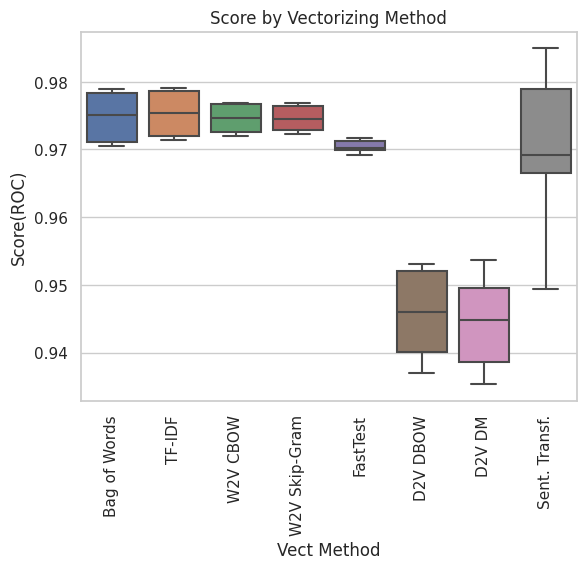

In [16]:
columns_name = {'level_0':'Text Type', 'level_1': 'Vect Method', 0: 'Score(ROC)'}
df_scores_vect_stack = df_scores_vect.stack().reset_index().rename(columns=columns_name)
df_scores_vect_stack['Vect Method & Text'] =  df_scores_vect_stack['Vect Method'] + ' ' + df_scores_vect_stack['Text Type']

ax = sns.boxplot(x='Vect Method',
                 y='Score(ROC)',
                 data=df_scores_vect_stack)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.title('Score by Vectorizing Method')
plt.plot()

[]

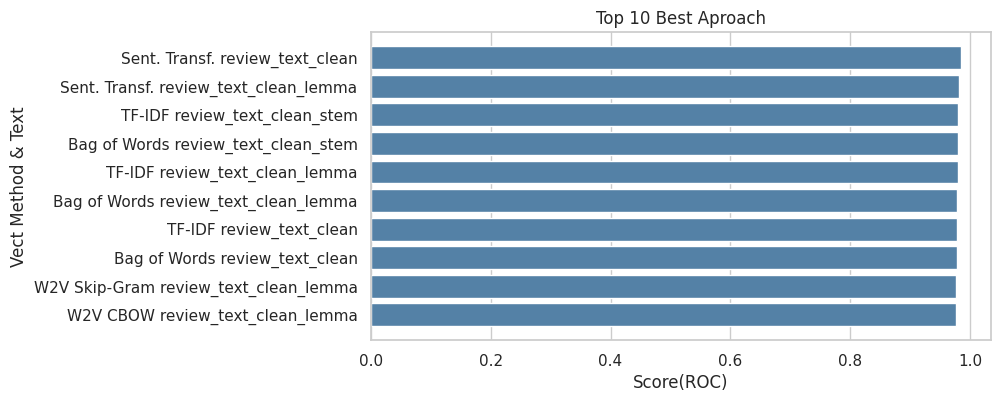

In [22]:
plt.figure(figsize=(8, 4))
ax = sns.barplot(x='Score(ROC)', y='Vect Method & Text',
                 data=df_scores_vect_stack.sort_values(by='Score(ROC)', ascending=False).head(10),
                 orient='h', color='steelblue')
ax.set_yticklabels(ax.get_yticklabels())
plt.title('Top 10 Best Aproach')
plt.plot()

[]

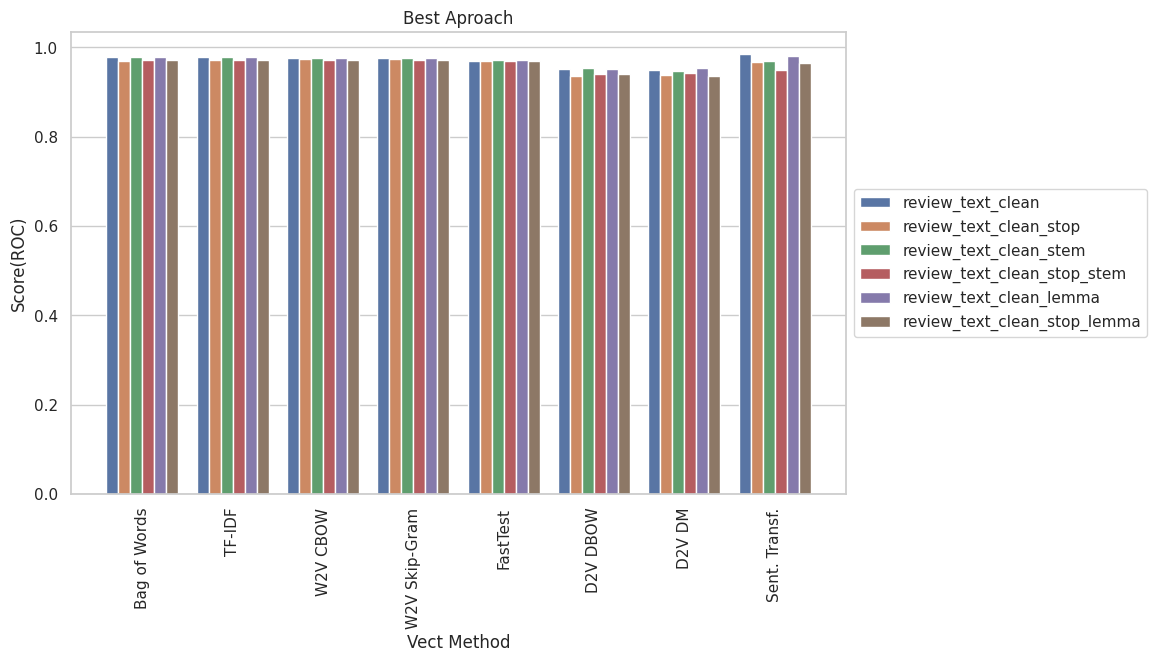

In [23]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Vect Method', y='Score(ROC)',
                 hue='Text Type',
                 data=df_scores_vect_stack,
                 )
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Best Aproach')
plt.plot()